## TWEET ANALYSIS AND CLEANING

A new dataset, "tweets.csv," has been provided to you. Similar to previous
practices, you are expected to perform a detailed text analysis. This includes understanding your data thoroughly,
performing text cleaning and analysis, and addressing a problem that you identify as solvable with the given data.

The tweets talk are about sentiment classification related to american airlines.
- US Airways
- United
- American
- Southwest
- Delta
- Virgin America

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
additional_data_path = "/content/drive/MyDrive/MEDS/Lesson6/Homework/"

In [3]:
filename = additional_data_path + 'tweets.csv'

Necessary imports to achieve our objective

In [4]:
! pip install textblob

In [5]:
! pip install textacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.4 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols, user_handles
from textacy.preprocessing.normalize import quotation_marks, bullet_points
from textacy.preprocessing.remove import punctuation
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols, user_handles
from textacy.preprocessing.normalize import quotation_marks, bullet_points
from textacy.preprocessing.remove import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Exploratory Data Analysis (EDA)

In [7]:
df_tweets = pd.read_csv(filename)

In [8]:
print('Number of tweets:', df_tweets.shape)
print('Info about the dataset:', df_tweets.info())
print('Sentiments:', df_tweets['airline_sentiment'].unique())
print('Airlines:', df_tweets['airline'].unique())

Number of tweets: (14640, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 

In [9]:
df_tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We can see that it is a very complete dataset as it haves columns like the sentiment, but we also notice that there are a lot of NaN values and we should treat this.

**Distribution of Tweets based on the sentiment**

In [10]:
sentiment_counts = df_tweets['airline_sentiment'].value_counts()
print('Number of tweets based on their sentiment:', sentiment_counts)

Number of tweets based on their sentiment: airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


<ipython-input-11-5bc1c629cd03>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df_tweets, palette=color)


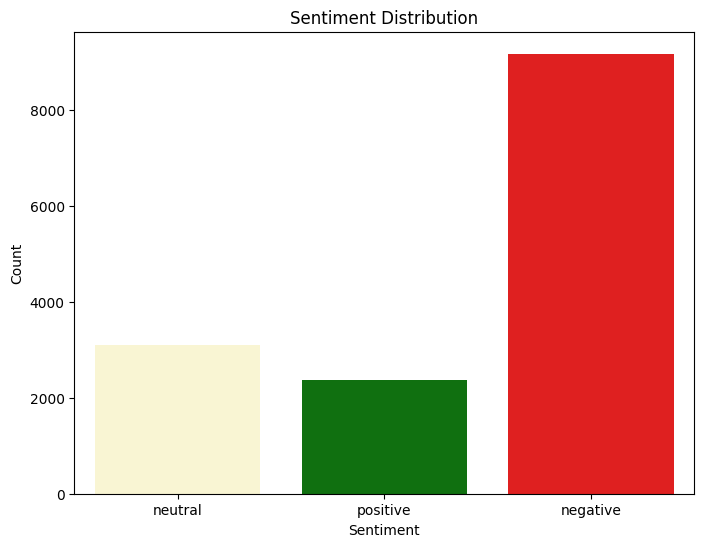

In [11]:
color=['lemonchiffon', 'green','red']
plt.figure(figsize=(8, 6))
sns.countplot(x='airline_sentiment', data=df_tweets, palette=color)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


We can see that we have a unbalaced dataset as we have much more tweets with negative sentiment than with neutral or positive.

**Distribution of airline sentiment confidence**

The *airline sentiment confidence* typically refers to the level of confidence or certainty associated with the sentiment classification of the tweets. In other words, this score is going to tell us how confident was the classifier when stating if a tweet was positive, neutral or negative.

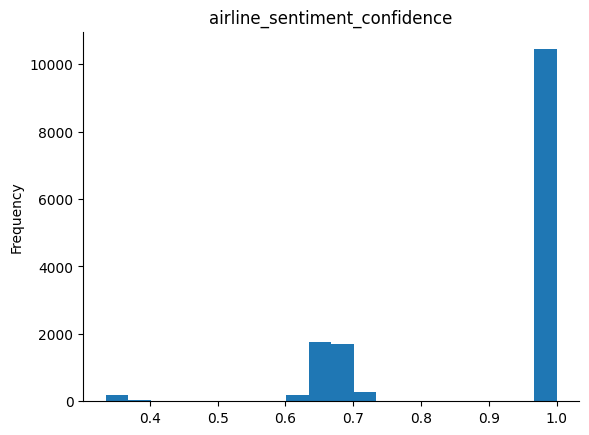

In [12]:
from matplotlib import pyplot as plt
df_tweets['airline_sentiment_confidence'].plot(kind='hist', bins=20, title='airline_sentiment_confidence')
plt.gca().spines[['top', 'right',]].set_visible(False)

We can conclude, that most of the tweets have been correctly classified.

**Distribution of tweets per arline**

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


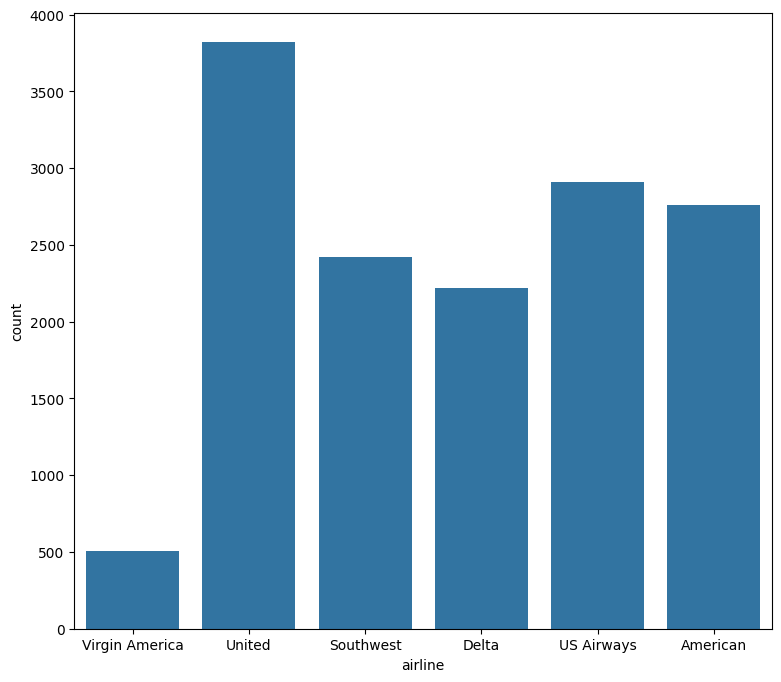

In [13]:
print("Total number of tweets for each airline \n ", df_tweets.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
plt.figure(figsize=(9,8))
ax = sns.countplot(x="airline", data=df_tweets)


**Distribution of sentiment tweets per airline**

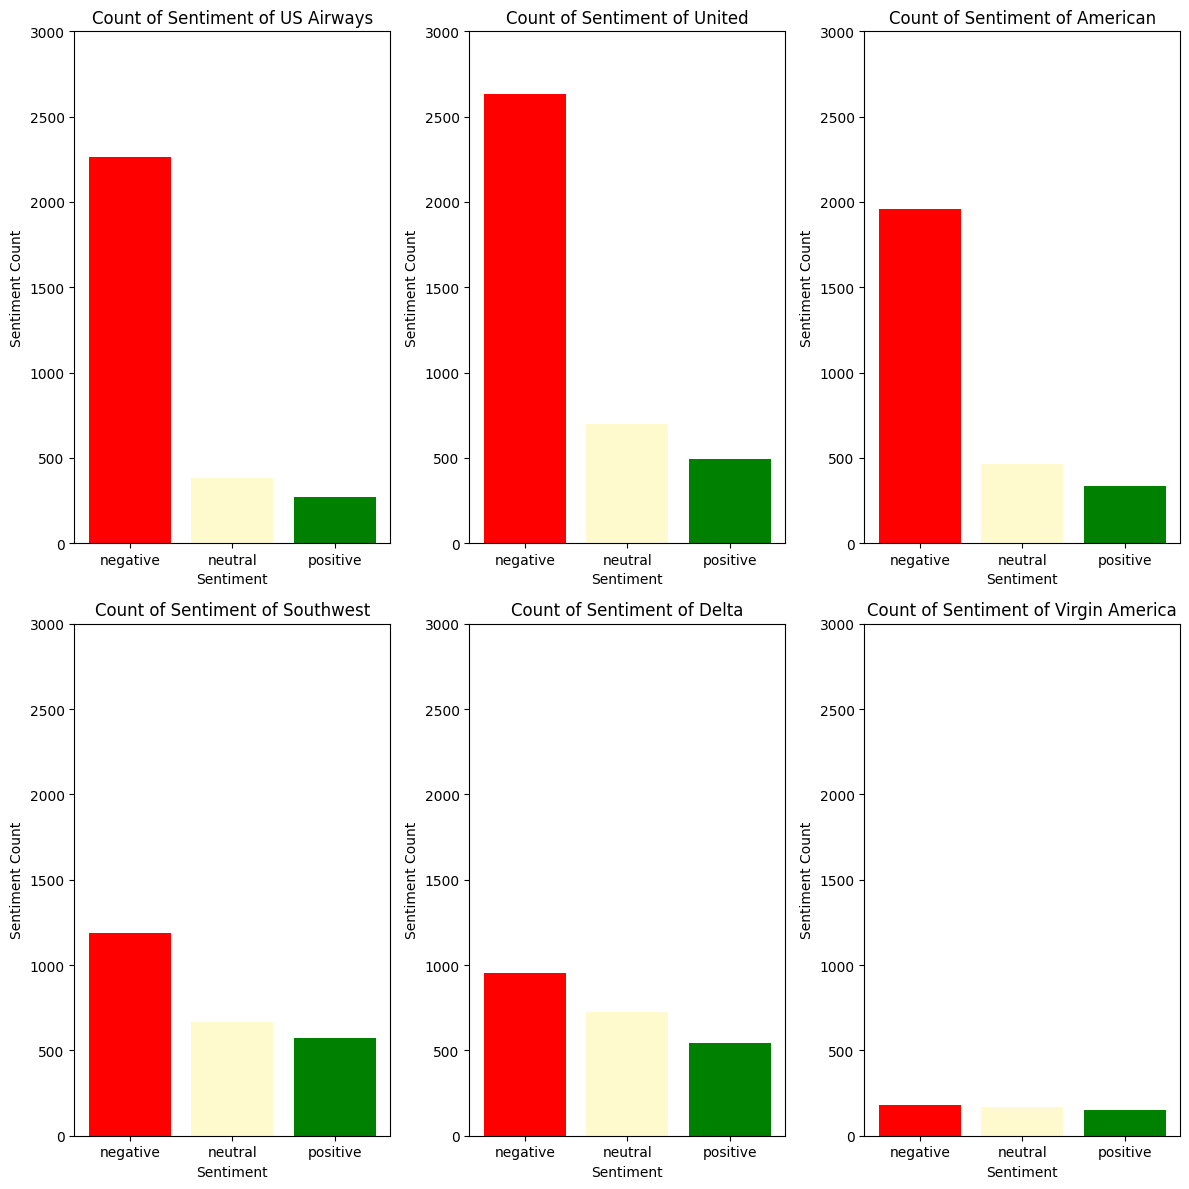

In [14]:
airlines = ['US Airways', 'United', 'American', 'Southwest', 'Delta', 'Virgin America']
plt.figure(1, figsize=(12, 12))
for i in airlines:
    indices = airlines.index(i)
    plt.subplot(2, 3, indices + 1)
    new_df = df_tweets[df_tweets['airline'] == i]
    count = new_df['airline_sentiment'].value_counts()
    Index = [1, 2, 3]
    plt.bar(Index, count, color=['red', 'lemonchiffon', 'green'])
    plt.xticks(Index, ['negative', 'neutral', 'positive'])
    plt.ylabel('Sentiment Count')
    plt.xlabel('Sentiment')
    plt.title('Count of Sentiment of ' + i)
    plt.ylim(0, 3000)  # Set y-axis limit to 0 and 3000 for all subplots

plt.tight_layout()
plt.show()

We can see that there are very few tweets about Virgin Airlines

**Word-related Information**

We are going to create the wordcloud for the positive and negative tweets, for this we are going to exclude the stopwords, and words with http, @ and RT.

Lets check the **wordcloud for negative**

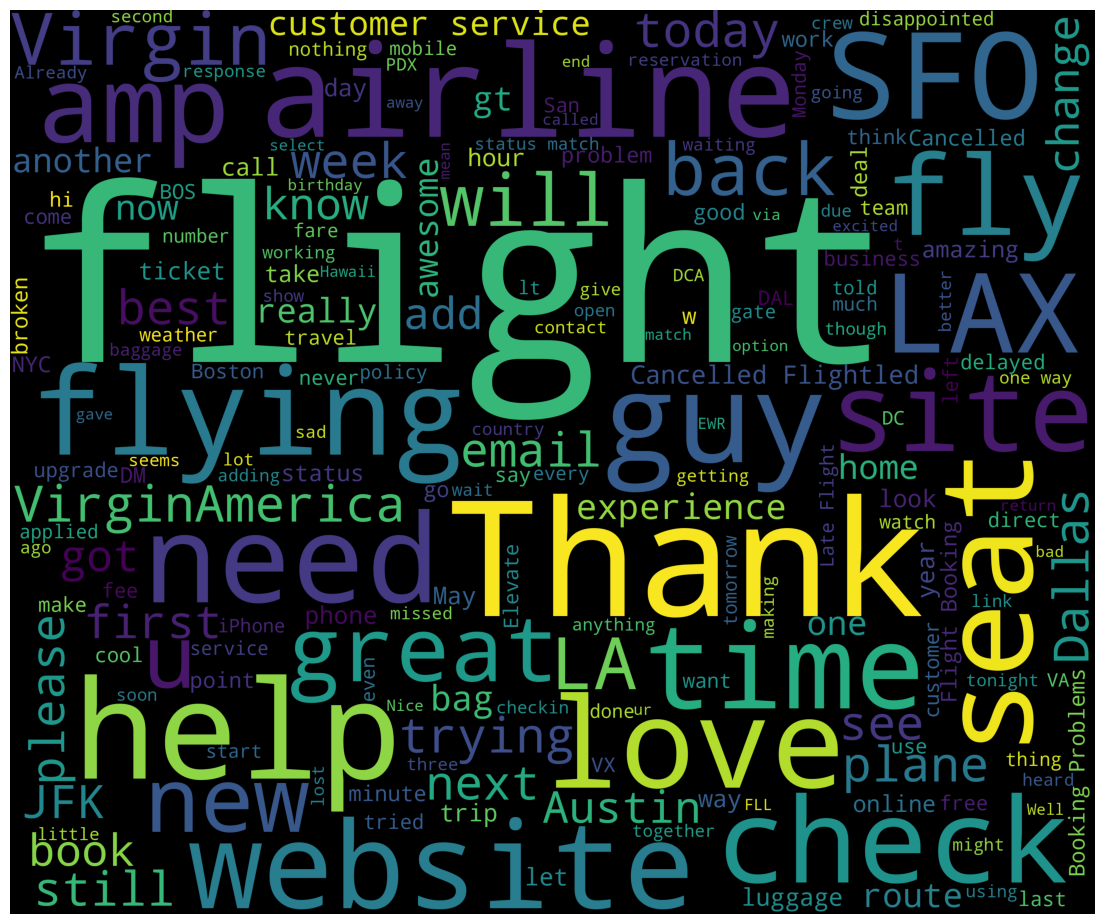

In [15]:
#wordcloud for negative tweets

df_negative=df_tweets[df_tweets['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(14, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Lets check the **wordcloud for the positive tweets**.

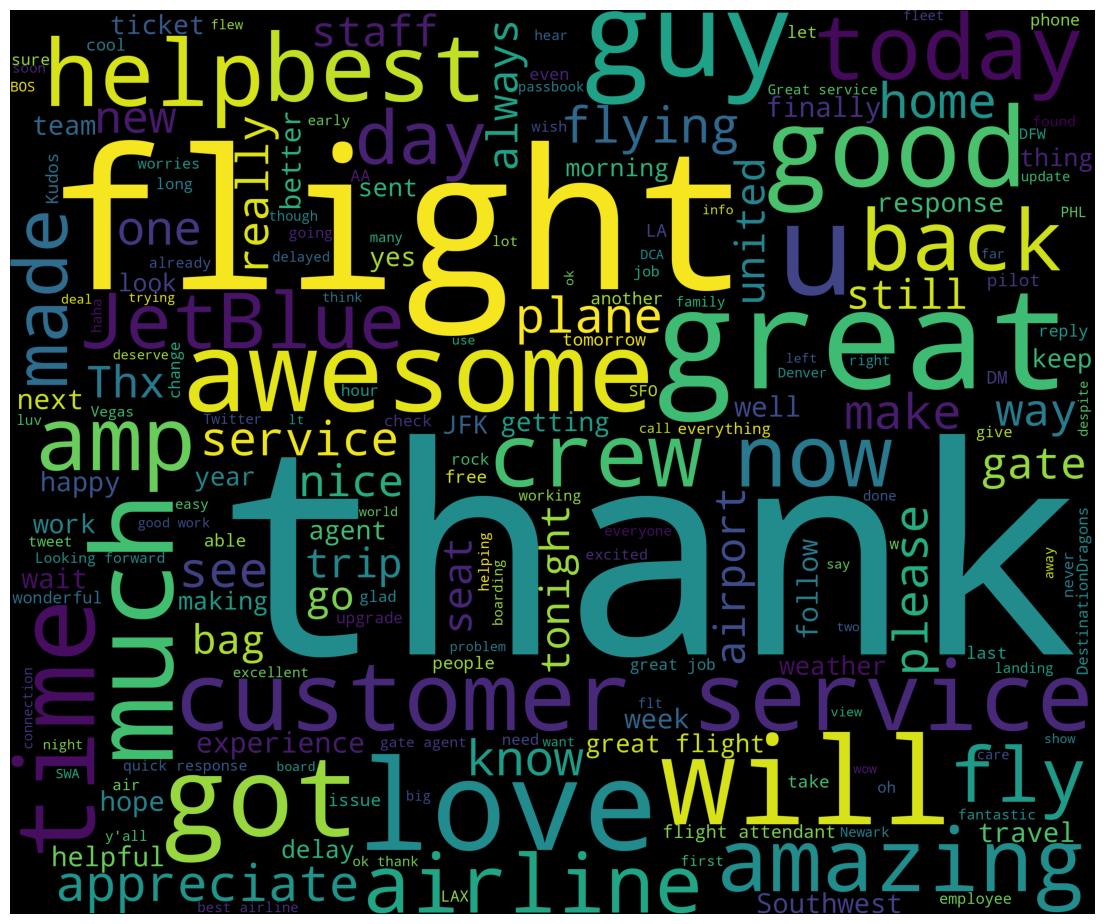

In [16]:
# word cloud for negative tweets

from wordcloud import WordCloud, STOPWORDS
df_positive=df_tweets[df_tweets['airline_sentiment']=='positive']
words = ' '.join(df_positive['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(14, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We are now going to try to find the **reasons for the negative tweets.**

 In order to do this we have to focus on the *negativereason* column of the dataframe. First we are going to plot all the negative reasons, and then we are going to plot the negative reasons for each airline, with this we can conclude wich are the main reason for the bad tweets of each airline.



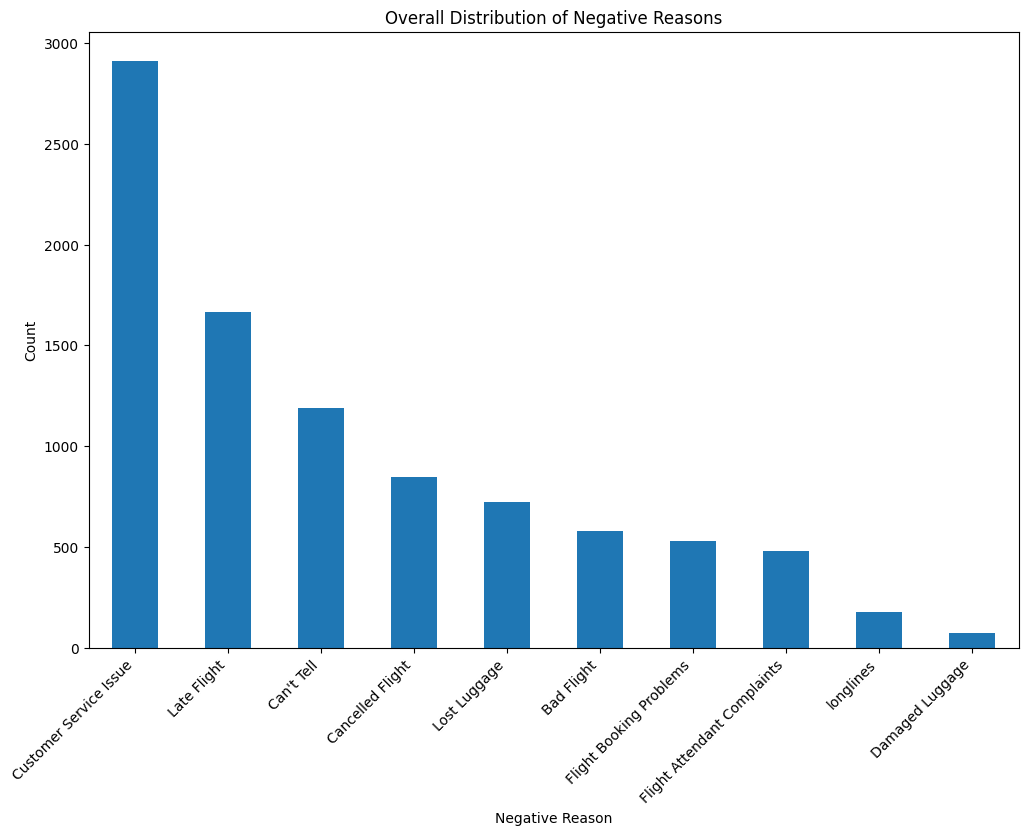

In [ ]:
## All the negative reasons

# Count the occurrences of each negative reason
neg_reason_counts = df_tweets['negativereason'].value_counts()

# Plot the overall distribution of negative reasons
plt.figure(figsize=(12, 8))
neg_reason_counts.plot(kind='bar')
plt.title('Overall Distribution of Negative Reasons')
plt.xlabel('Negative Reason')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

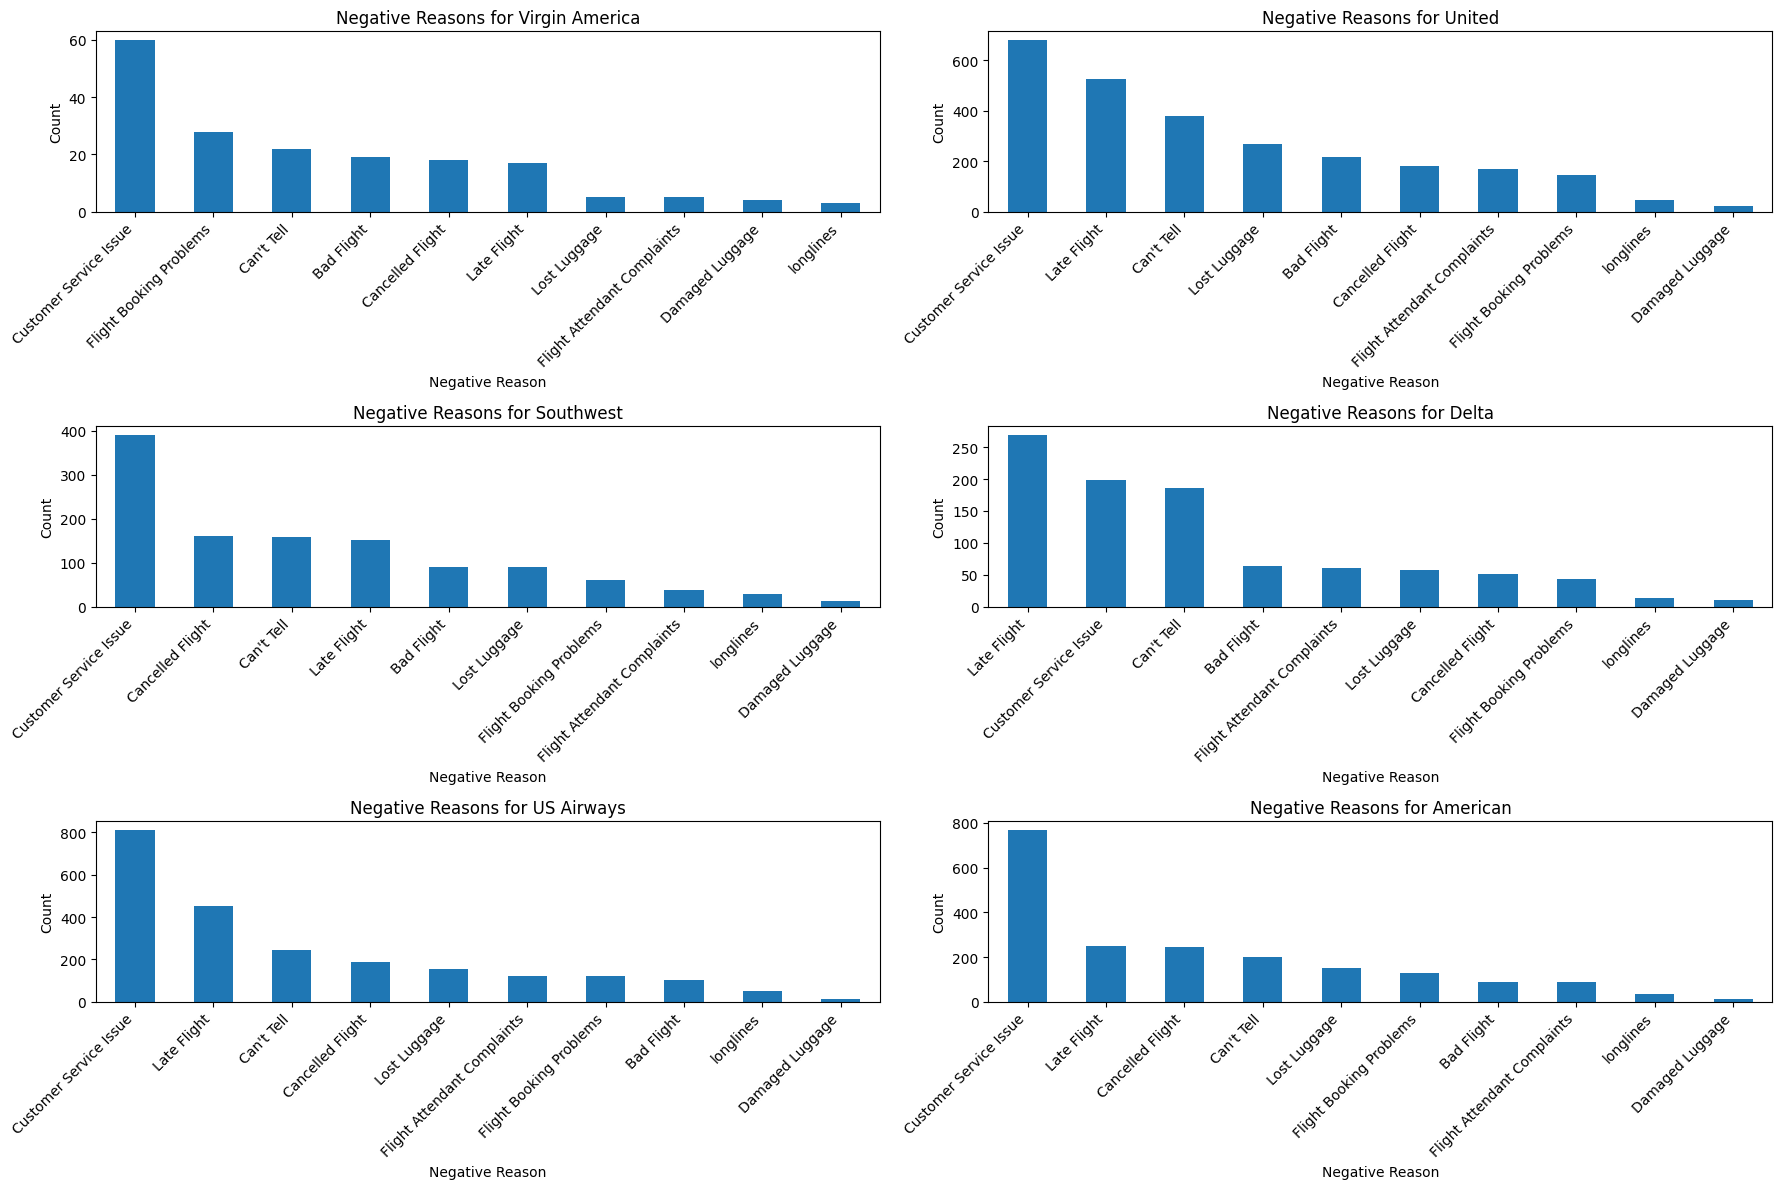

In [ ]:
# Get the list of airlines
airlines = df_tweets['airline'].unique()

# Create a figure for subplots
plt.figure(figsize=(18, 12))

# Loop through each airline and plot the distribution of negative reasons
for i, airline in enumerate(airlines):
    plt.subplot(3, 2, i + 1)  # Adjust the grid size if necessary
    neg_reason_counts = df_tweets[df_tweets['airline'] == airline]['negativereason'].value_counts()
    neg_reason_counts.plot(kind='bar')
    plt.title(f'Negative Reasons for {airline}')
    plt.xlabel('Negative Reason')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In all of the airlines except for Delta, the main negative reason is Customer Service Issue. For Delta airlines the ain reason is Late Flight.

**Check the null and duplicate values**

We are going to check the number of null, empty and duplicate tweets in order to deal with them in the next section.

In [9]:
# check the null value
null_count = df_tweets.isnull().sum()
print('Number of NaN Values:', null_count )

# check empty tweets
empty_count = df_tweets[df_tweets.text.str.strip()==''].count()
print('Number of Empty Tweets', empty_count)

# check duplicates
duplicates_count = df_tweets.duplicated().sum()
print('Number of duplicates', duplicates_count)

Number of NaN Values: tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
Number of Empty Tweets tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
airline_sentiment_gold          0
name                            0
negativereason_gold             0
retweet_count                   0
text                            

## Data Preprocessing and Cleaning

We are going to clean the text and save the cleaned text in a new column.

**Remove duplicates**

In [10]:
df_tweets.drop_duplicates(inplace=True)
df_tweets.reset_index(inplace=True, drop=True)

**StopWordRemoval**

In [11]:
stopwords = set(stopwords.words('english'))
punctuation = set(string.punctuation)

stopwords.update(punctuation)

def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stopwords]
  return ' '.join(filtered_words)

In [12]:
df_tweets['cleaned_text'] = df_tweets['text'].apply(remove_stopwords)

**Lower Casing**

Although, uppercase words can be significant in the sentiment analysis, as in the report for sentiment analysis, we are going to transform all the text into lowercase.

In [13]:
df_tweets['cleaned_text'] = df_tweets['cleaned_text'].str.lower()

**Remove Hashtags and @**

In [14]:
def remove_special_characters(text):
    # Remove special characters except alphanumeric characters, spaces, and single quotes
    return re.sub(r'[^a-zA-Z0-9\s\']', '', text)

In [15]:
df_tweets['cleaned_text'] = df_tweets['cleaned_text'].apply(remove_special_characters)

**Removing Emojis**

In [16]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [17]:
df_tweets['cleaned_text'] = df_tweets['cleaned_text'].apply(remove_emoji)

**Remove Emoticons**

In [18]:
import pickle
with open("/content/drive/MyDrive/MEDS/Lesson6/Homework/1_Amazon_Reviews_Sentiment_Analysis_Topic_Modelling/Emoticon_Dict.p", 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)

In [19]:
df_tweets['cleaned_text'] = df_tweets['cleaned_text'].apply(remove_emoticons)

**Spell Correction**

This takes a lot of time since we have a lot of tweets. (We will only apply it to the first 5 rows to see the effect)

In [20]:
from textblob import TextBlob
df_tweets['cleaned_text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                           virginamerica hepburn said
1    virginamerica plus added commercial experience...
2    virginamerica today must mean need take anothe...
3    virginamerica really aggressive blast obnoxiou...
4                   virginamerica really big bad thing
Name: cleaned_text, dtype: object

We are also going to add, to make sure the functions of cleaning text in the Data Cleaning and Feature Extraction Pyhton Notebook from Amazon Reviews

In [21]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [22]:
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [23]:
df_tweets['cleaned_text'] = df_tweets['cleaned_text'].apply(clean_text_round1)
df_tweets['cleaned_text'] = df_tweets['cleaned_text'].apply(clean_text_round2)

In [24]:
df_tweets['cleaned_text'].head()

0                          virginamerica dhepburn said
1    virginamerica plus added commercials experienc...
2    virginamerica today must mean need take anothe...
3    virginamerica really aggressive blast obnoxiou...
4                   virginamerica really big bad thing
Name: cleaned_text, dtype: object

**Stemming**

We create a column for the stemmed text

In [25]:
# Initiliaze the SnowballStemmer
stemmer = SnowballStemmer('english')

def apply_stemming(text):
  words = text.split()
  stemmed_words = [stemmer.stem(word) for word in words]
  return ' '.join(stemmed_words)

In [26]:
df_tweets['stemmed_text'] = df_tweets['cleaned_text'].apply(apply_stemming)

In [27]:
df_tweets['stemmed_text'].head()

0                          virginamerica dhepburn said
1          virginamerica plus ad commerci experi tacki
2    virginamerica today must mean need take anoth ...
3    virginamerica realli aggress blast obnoxi ente...
4                   virginamerica realli big bad thing
Name: stemmed_text, dtype: object

We create a stemmed vocabulary

In [28]:
totalvocab_stemmed = []
for i in df_tweets['stemmed_text']:
   totalvocab_stemmed.extend(df_tweets['stemmed_text'])
stemmed_vocab = list(totalvocab_stemmed)

In [29]:
df_tweets['stemmed_text'].head(5)

0                          virginamerica dhepburn said
1          virginamerica plus ad commerci experi tacki
2    virginamerica today must mean need take anoth ...
3    virginamerica realli aggress blast obnoxi ente...
4                   virginamerica realli big bad thing
Name: stemmed_text, dtype: object

In [30]:
stemmed_vocab

['virginamerica dhepburn said',
 'virginamerica plus ad commerci experi tacki',
 'virginamerica today must mean need take anoth trip',
 'virginamerica realli aggress blast obnoxi entertain guest face amp littl recours',
 'virginamerica realli big bad thing',
 'virginamerica serious would pay flight seat play realli bad thing fli va',
 'virginamerica yes near everi time fli vx ear worm wont go away',
 'virginamerica realli miss prime opportun men without hat parodi there',
 'virginamerica well didntbut do d',
 'virginamerica amaz arriv hour earli good me',
 'virginamerica know suicid second lead caus death among teen',
 'virginamerica pretti graphic much better minim iconographi d',
 'virginamerica great deal alreadi think trip australia amp even gone trip yet p',
 'virginamerica virginmedia im fli fabul seduct sky again u take stress away travel httptcoahlxhhkiyn',
 'virginamerica thank',
 'virginamerica sfopdx schedul still mia',
 'virginamerica excit first cross countri flight lax mc

**Tokenization**

We are going to create a new column to save the tokens extracted from each tweet

In [31]:
def tokenize_only(text):
  # tokenize by sentence, then by word to ensure punctuation is caught as its own token (although is removed)
  tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  filtered_tokens = []
  # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
  for token in tokens:
      if re.search('[a-zA-Z]', token):
          filtered_tokens.append(token)
  return filtered_tokens

In [32]:
df_tweets['tokenized_text'] = df_tweets['cleaned_text'].apply(tokenize_only)

In [33]:
df_tweets['tokenized_text'].head()

0                      [virginamerica, dhepburn, said]
1    [virginamerica, plus, added, commercials, expe...
2    [virginamerica, today, must, mean, need, take,...
3    [virginamerica, really, aggressive, blast, obn...
4             [virginamerica, really, big, bad, thing]
Name: tokenized_text, dtype: object

We create a tokenized vocabulary

In [34]:
totalvocab_tokenized = []
for i in df_tweets['stemmed_text']:
   totalvocab_tokenized.extend(df_tweets['stemmed_text'])
tokenized_vocab = list(totalvocab_tokenized)

In [35]:
tokenized_vocab

['virginamerica dhepburn said',
 'virginamerica plus ad commerci experi tacki',
 'virginamerica today must mean need take anoth trip',
 'virginamerica realli aggress blast obnoxi entertain guest face amp littl recours',
 'virginamerica realli big bad thing',
 'virginamerica serious would pay flight seat play realli bad thing fli va',
 'virginamerica yes near everi time fli vx ear worm wont go away',
 'virginamerica realli miss prime opportun men without hat parodi there',
 'virginamerica well didntbut do d',
 'virginamerica amaz arriv hour earli good me',
 'virginamerica know suicid second lead caus death among teen',
 'virginamerica pretti graphic much better minim iconographi d',
 'virginamerica great deal alreadi think trip australia amp even gone trip yet p',
 'virginamerica virginmedia im fli fabul seduct sky again u take stress away travel httptcoahlxhhkiyn',
 'virginamerica thank',
 'virginamerica sfopdx schedul still mia',
 'virginamerica excit first cross countri flight lax mc

**Tokenized and Stem**

In [36]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return ' '.join(stems)

In [37]:
df_tweets['token_stem'] = df_tweets['cleaned_text'].apply(tokenize_and_stem)

In [38]:
df_tweets['token_stem'].head()

0                          virginamerica dhepburn said
1          virginamerica plus ad commerci experi tacki
2    virginamerica today must mean need take anoth ...
3    virginamerica realli aggress blast obnoxi ente...
4                   virginamerica realli big bad thing
Name: token_stem, dtype: object

At last, in order to apply a machine learning for classification we are going to erase the neural tweets, and we are going to apply a binary system. The proportion of neutral tweets is little so erasing them shouldn't be a problem.

In [39]:
# Removing Neutral Tweets
df_tweets = df_tweets[df_tweets['airline_sentiment'] != 'neutral']

# Reset the index if needed
df_tweets.reset_index(drop=True, inplace=True)

In [40]:
df_tweets.shape

(11513, 19)

In [41]:
df_tweets['airline_sentiment_binary'] = df_tweets['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)

## Model  Prediction, Sentiment Classification

In this section we are going to evaluate different models.
- Naive Bayes with Gaussian Method
- Multinomial Naive Bayes
- Bernoulli Naive Bayes
- Logistic Regression

We starts by splitting our dataset into **train and testing sets**

In [ ]:
X = df_tweets["cleaned_text"]
y = df_tweets["airline_sentiment_binary"]

In [42]:
X = df_tweets["token_stem"]
y = df_tweets["airline_sentiment_binary"]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**TF-IDF matrix**



In [44]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 1000)

# Fit and transform the training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

In [45]:
print("TF-ID Training Matrix Shape:", X_train_tfidf.shape)
print("TF-ID Testing Matrix Shape:", X_test_tfidf.shape)

TF-ID Training Matrix Shape: (9210, 1000)
TF-ID Testing Matrix Shape: (2303, 1000)


If we print the TF-IDF matrix

In [46]:
print("TF-ID Training Matrix:", X_train_tfidf)
print("TF-ID Testing Matrix:", X_test_tfidf)

TF-ID Training Matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
TF-ID Testing Matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**SVM**

In [48]:
from sklearn import model_selection, svm
from sklearn.metrics import confusion_matrix

classifier_svm = svm.SVC(probability=True);
classifier_svm.fit(X_train_tfidf, y_train)
cv_svm = classifier_svm.fit(X_train_tfidf, y_train) # This will be used later for model comparison

# predicting train set results
y_pred_train = classifier_svm.predict(X_train_tfidf)

# predicting test set results
y_pred = classifier_svm.predict(X_test_tfidf)

# making the confusion matrix
cm_svm = confusion_matrix(y_test, y_pred)
cm_svm

array([[1801,   39],
       [ 174,  289]])

Text(113.9222222222222, 0.5, 'Predicted label')

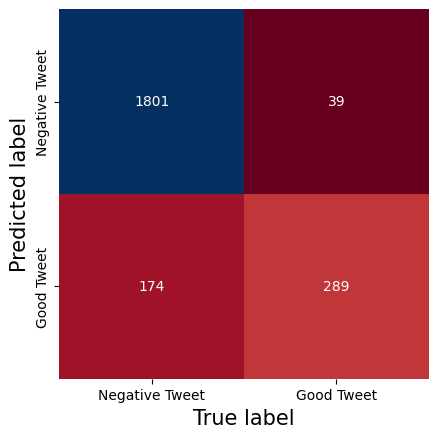

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm_svm, square=True, annot=True, cmap='RdBu', cbar=False, fmt='d', # fmt='d' gets rid of numbers like 1.8e + 02
xticklabels=['Negative Tweet', 'Good Tweet'],
yticklabels=['Negative Tweet', 'Good Tweet'])
plt.xlabel('True label', fontsize= 15)
plt.ylabel('Predicted label',fontsize= 15)

In [50]:
# Metrics for training

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svm_train_acc = accuracy_score(y_train, y_pred_train)

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_train, y_pred_train)))
print('Precision score: {0:0.2f}'.format(precision_score(y_train, y_pred_train)))
print('Recall score: {0:0.2f}'.format(recall_score(y_train, y_pred_train)))
print('F1 score: {0:0.2f}'.format(f1_score(y_train, y_pred_train, average='micro')))

Accuracy score: 0.97
Precision score: 0.98
Recall score: 0.89
F1 score: 0.97


In [51]:
# Metrics for testing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svm_test_acc = accuracy_score(y_test, y_pred)

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred)))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred)))
print('F1 score: {0:0.2f}'.format(f1_score(y_test, y_pred, average='micro')))

Accuracy score: 0.91
Precision score: 0.88
Recall score: 0.62
F1 score: 0.91


**Naive Bayes with Gaussian Model**

In [54]:
# Fitting naive bayes to the training set with Gaussian Method
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

classifier_GNB = GaussianNB();
classifier_GNB.fit(X_train_tfidf, y_train)
cv_gaussian= classifier_GNB.fit(X_train_tfidf, y_train) # This will be used later for model comparison

# predicting train set results
y_pred_train = classifier_GNB.predict(X_train_tfidf)

# predicting test set results
y_pred = classifier_GNB.predict(X_test_tfidf)

# making the confusion matrix
cm_gaussianNB = confusion_matrix(y_test, y_pred)
cm_gaussianNB

array([[904, 936],
       [ 46, 417]])

Text(113.9222222222222, 0.5, 'Predicted label')

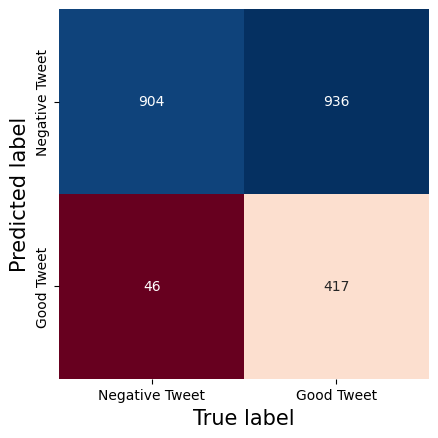

In [55]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm_gaussianNB, square=True, annot=True, cmap='RdBu', cbar=False, fmt='d', # fmt='d' gets rid of numbers like 1.8e + 02
xticklabels=['Negative Tweet', 'Good Tweet'],
yticklabels=['Negative Tweet', 'Good Tweet'])
plt.xlabel('True label', fontsize= 15)
plt.ylabel('Predicted label',fontsize= 15)

In [56]:
#Metrics for training

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

g_train_acc = accuracy_score(y_train, y_pred_train)

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_train, y_pred_train)))
print('Precision score: {0:0.2f}'.format(precision_score(y_train, y_pred_train)))
print('Recall score: {0:0.2f}'.format(recall_score(y_train, y_pred_train)))
print('F1 score: {0:0.2f}'.format(f1_score(y_train, y_pred_train, average='micro')))

Accuracy score: 0.59
Precision score: 0.33
Recall score: 0.99
F1 score: 0.59


In [57]:
# Metrics for testing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

g_test_acc = accuracy_score(y_test, y_pred)

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred)))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred)))
print('F1 score: {0:0.2f}'.format(f1_score(y_test, y_pred, average='micro')))

Accuracy score: 0.57
Precision score: 0.31
Recall score: 0.90
F1 score: 0.57


**Multinomial Naive Bayes**

In [58]:
from sklearn.naive_bayes import MultinomialNB

classifier_MNB = MultinomialNB()
classifier_MNB.fit(X_train_tfidf, y_train)
cv_mn = classifier_MNB.fit(X_train_tfidf, y_train) # This will be used later for model comparison

# predicting train set results
y_pred_train = classifier_MNB.predict(X_train_tfidf)

# predicting test set results
y_pred = classifier_MNB.predict(X_test_tfidf)

# making the confusion matrix
cm_multiBayes = confusion_matrix(y_test, y_pred)
cm_multiBayes

array([[1824,   16],
       [ 240,  223]])

Text(113.9222222222222, 0.5, 'Predicted label')

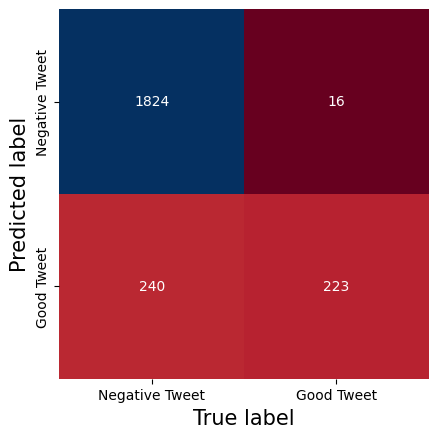

In [59]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm_multiBayes, square=True, annot=True, cmap='RdBu', cbar=False, fmt='d', # fmt='d' gets rid of numbers like 1.8e + 02
xticklabels=['Negative Tweet', 'Good Tweet'],
yticklabels=['Negative Tweet', 'Good Tweet'])
plt.xlabel('True label', fontsize= 15)
plt.ylabel('Predicted label',fontsize= 15)

In [60]:
#Metrics for training

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

m_train_acc = accuracy_score(y_train, y_pred_train)

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_train, y_pred_train)))
print('Precision score: {0:0.2f}'.format(precision_score(y_train, y_pred_train)))
print('Recall score: {0:0.2f}'.format(recall_score(y_train, y_pred_train)))
print('F1 score: {0:0.2f}'.format(f1_score(y_train, y_pred_train, average='micro')))

Accuracy score: 0.90
Precision score: 0.95
Recall score: 0.55
F1 score: 0.90


In [61]:
# Metrics for testing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

m_test_acc = accuracy_score(y_test, y_pred)

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred)))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred)))
print('F1 score: {0:0.2f}'.format(f1_score(y_test, y_pred, average='micro')))

Accuracy score: 0.89
Precision score: 0.93
Recall score: 0.48
F1 score: 0.89


**Bernoulli Naive Bayes**

In [62]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

classifier_BNB = BernoulliNB();
classifier_BNB.fit(X_train_tfidf, y_train)
cv_ber= classifier_BNB.fit(X_train_tfidf, y_train) # This will be used later for model comparison

# predicting train set results
y_pred_train = classifier_BNB.predict(X_train_tfidf)

# predicting test set results
y_pred = classifier_BNB.predict(X_test_tfidf)

# making the confusion matrix
cm_bernoulli = confusion_matrix(y_test, y_pred)
cm_bernoulli

array([[1723,  117],
       [  94,  369]])

Text(113.9222222222222, 0.5, 'Predicted label')

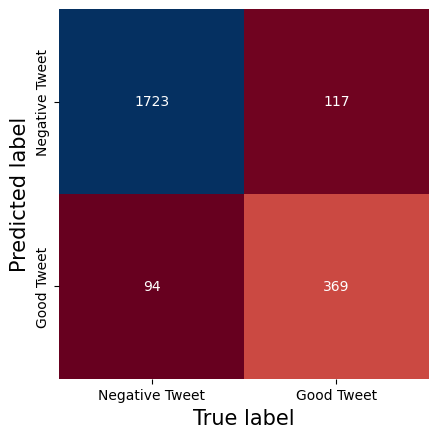

In [63]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm_bernoulli, square=True, annot=True, cmap='RdBu', cbar=False, fmt='d', # fmt='d' gets rid of numbers like 1.8e + 02
xticklabels=['Negative Tweet', 'Good Tweet'],
yticklabels=['Negative Tweet', 'Good Tweet'])
plt.xlabel('True label', fontsize= 15)
plt.ylabel('Predicted label',fontsize= 15)

In [64]:
#Metrics for training

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

b_train_acc = accuracy_score(y_train, y_pred_train)

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_train, y_pred_train)))
print('Precision score: {0:0.2f}'.format(precision_score(y_train, y_pred_train)))
print('Recall score: {0:0.2f}'.format(recall_score(y_train, y_pred_train)))
print('F1 score: {0:0.2f}'.format(f1_score(y_train, y_pred_train, average='micro')))

Accuracy score: 0.92
Precision score: 0.77
Recall score: 0.83
F1 score: 0.92


In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

b_test_acc = accuracy_score(y_test, y_pred)

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred)))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred)))
print('F1 score: {0:0.2f}'.format(f1_score(y_test, y_pred, average='micro')))

Accuracy score: 0.91
Precision score: 0.76
Recall score: 0.80
F1 score: 0.91


**Logistic Regresion Model**

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)
cv_logreg= logreg.fit(X_train_tfidf, y_train)

# predicting train set results
y_pred_train = logreg.predict(X_train_tfidf)

# predicting test set results
y_pred = logreg.predict(X_test_tfidf)

Text(113.9222222222222, 0.5, 'Predicted label')

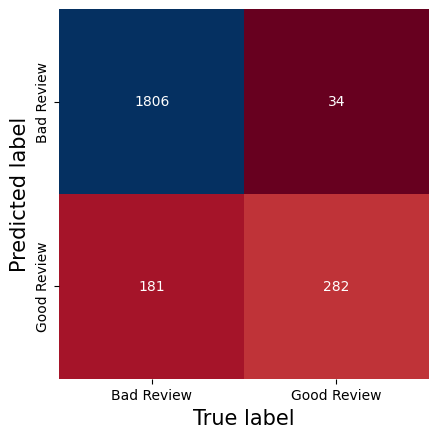

In [70]:
# making the confusion matrix
cm_log = confusion_matrix(y_test, y_pred)

sns.heatmap(cm_log, square=True, annot=True, cmap='RdBu', cbar=False, fmt='d',
xticklabels=['Bad Review', 'Good Review'],
yticklabels=['Bad Review', 'Good Review'])
plt.xlabel('True label', fontsize= 15)
plt.ylabel('Predicted label',fontsize= 15)

In [71]:
#Metrics for training

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_train_acc = accuracy_score(y_train, y_pred_train)

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_train, y_pred_train)))
print('Precision score: {0:0.2f}'.format(precision_score(y_train, y_pred_train)))
print('Recall score: {0:0.2f}'.format(recall_score(y_train, y_pred_train)))
print('F1 score: {0:0.2f}'.format(f1_score(y_train, y_pred_train, average='micro')))

Accuracy score: 0.92
Precision score: 0.92
Recall score: 0.68
F1 score: 0.92


In [72]:
#Metrics for testing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_test_acc = accuracy_score(y_test, y_pred)

print('Accuracy score: {0:0.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score: {0:0.2f}'.format(precision_score(y_test, y_pred)))
print('Recall score: {0:0.2f}'.format(recall_score(y_test, y_pred)))
print('F1 score: {0:0.2f}'.format(f1_score(y_test, y_pred, average='micro')))

Accuracy score: 0.91
Precision score: 0.89
Recall score: 0.61
F1 score: 0.91


**ROC Curves**

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [74]:
# Get predicted probabilities for each classifiers from fitted classifiers (TRAINING)
y_score0_tr = cv_svm.predict_proba(X_train_tfidf)[:,1]
y_score1_tr = cv_gaussian.predict_proba(X_train_tfidf)[:,1]
y_score2_tr = cv_mn.predict_proba(X_train_tfidf)[:,1]
y_score3_tr = cv_ber.predict_proba(X_train_tfidf)[:,1]
y_score4_tr = cv_logreg.predict_proba(X_train_tfidf)[:,1]

# Plot Receiving Operating Characteristic Curve
  # Create true and false positive rates
false_positive_rate0, true_positive_rate0, threshold0 = roc_curve(y_train, y_score0_tr)
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_train, y_score1_tr)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_train, y_score2_tr)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_train, y_score3_tr)
false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_train, y_score4_tr)

svm_train_auc = roc_auc_score(y_train, y_score0_tr)
g_train_auc = roc_auc_score(y_train, y_score1_tr)
m_train_auc = roc_auc_score(y_train, y_score2_tr)
b_train_auc = roc_auc_score(y_train, y_score3_tr)
log_train_auc = roc_auc_score(y_train, y_score4_tr)

print('roc_auc_score for SVM: {0:0.2f}'.format (roc_auc_score(y_train, y_score0_tr)))
print('roc_auc_score for Gaussian NB: {0:0.2f}'.format (roc_auc_score(y_train, y_score1_tr)))
print('roc_auc_score for Multinominal NB: {0:0.2f}'.format (roc_auc_score(y_train, y_score2_tr)))
print('roc_auc_score for Bernoulli NB: {0:0.2f}'.format (roc_auc_score(y_train, y_score3_tr)))
print('roc_auc_score for Logistic Regression: {0:0.2f}'.format (roc_auc_score(y_train, y_score4_tr)))

roc_auc_score for SVM: 1.00
roc_auc_score for Gaussian NB: 0.74
roc_auc_score for Multinominal NB: 0.96
roc_auc_score for Bernoulli NB: 0.96
roc_auc_score for Logistic Regression: 0.97


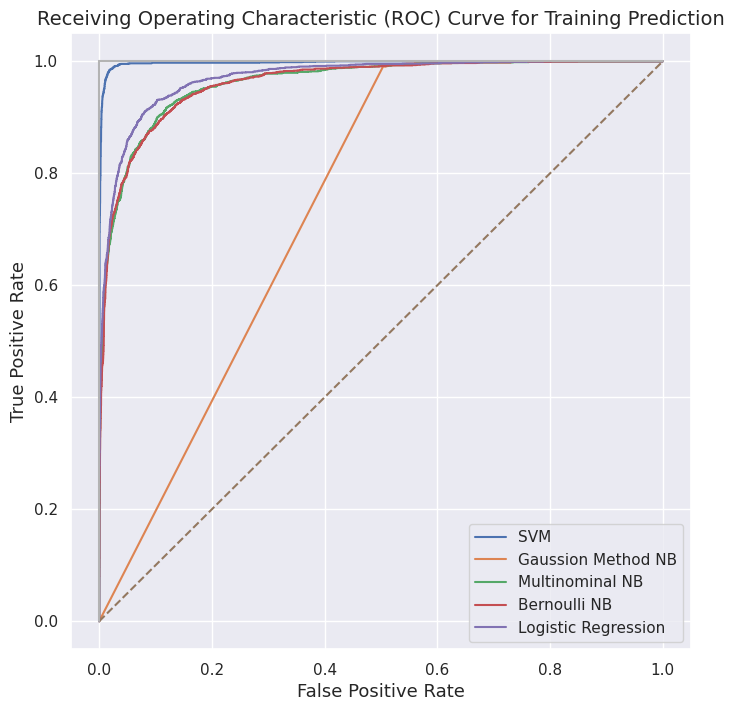

In [75]:
# PLOTTING THE CURVES FOR TRAINING

sns.set(style="darkgrid", color_codes=True)
plt.figure(figsize= (8,8))
plt.plot(false_positive_rate0, true_positive_rate0, label="SVM")
plt.plot(false_positive_rate1, true_positive_rate1, label="Gaussion Method NB")
plt.plot(false_positive_rate2, true_positive_rate2, label="Multinominal NB")
plt.plot(false_positive_rate3, true_positive_rate3, label="Bernoulli NB")
plt.plot(false_positive_rate4, true_positive_rate4, label="Logistic Regression")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate', fontsize= 13)
plt.xlabel('False Positive Rate', fontsize= 13)
plt.title('Receiving Operating Characteristic (ROC) Curve for Training Prediction', fontsize= 14)
plt.legend()
plt.show()

In [76]:
# Get predicted probabilities for each classifiers from fitted classifiers (TESTING)
y_score0 = cv_svm.predict_proba(X_test_tfidf)[:,1]
y_score1 = cv_gaussian.predict_proba(X_test_tfidf)[:,1]
y_score2 = cv_mn.predict_proba(X_test_tfidf)[:,1]
y_score3 = cv_ber.predict_proba(X_test_tfidf)[:,1]
y_score4 = cv_logreg.predict_proba(X_test_tfidf)[:,1]

# Plot Receiving Operating Characteristic Curve
  # Create true and false positive rates
false_positive_rate0, true_positive_rate0, threshold0 = roc_curve(y_test, y_score0)
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_score3)
false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_test, y_score4)

svm_test_auc = roc_auc_score(y_test, y_score0)
g_test_auc = roc_auc_score(y_test, y_score1)
m_test_auc = roc_auc_score(y_test, y_score2)
b_test_auc = roc_auc_score(y_test, y_score3)
log_test_auc = roc_auc_score(y_test, y_score4)


print('roc_auc_score for SVM: {0:0.2f}'.format (roc_auc_score(y_test, y_score0)))
print('roc_auc_score for Gaussian NB: {0:0.2f}'.format (roc_auc_score(y_test, y_score1)))
print('roc_auc_score for Multinominal NB: {0:0.2f}'.format (roc_auc_score(y_test, y_score2)))
print('roc_auc_score for Bernoulli NB: {0:0.2f}'.format (roc_auc_score(y_test, y_score3)))
print('roc_auc_score for Logistic Regression: {0:0.2f}'.format (roc_auc_score(y_test, y_score4)))

roc_auc_score for SVM: 0.95
roc_auc_score for Gaussian NB: 0.70
roc_auc_score for Multinominal NB: 0.94
roc_auc_score for Bernoulli NB: 0.94
roc_auc_score for Logistic Regression: 0.95


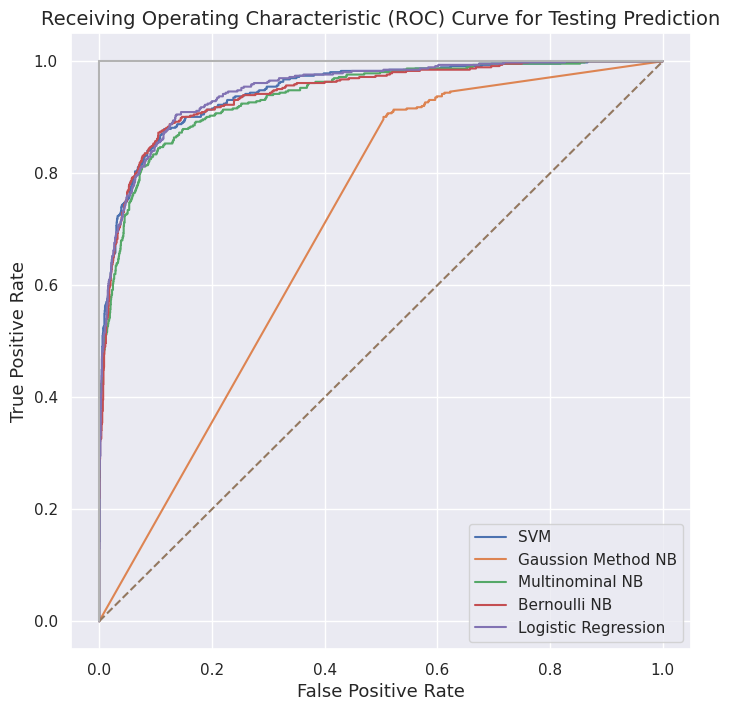

In [77]:
# PLOTTING THE CURVES FOR TESTING

sns.set(style="darkgrid", color_codes=True)
plt.figure(figsize= (8,8))
plt.plot(false_positive_rate0, true_positive_rate0, label="SVM")
plt.plot(false_positive_rate1, true_positive_rate1, label="Gaussion Method NB")
plt.plot(false_positive_rate2, true_positive_rate2, label="Multinominal NB")
plt.plot(false_positive_rate3, true_positive_rate3, label="Bernoulli NB")
plt.plot(false_positive_rate4, true_positive_rate4, label="Logistic Regression")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate', fontsize= 13)
plt.xlabel('False Positive Rate', fontsize= 13)
plt.title('Receiving Operating Characteristic (ROC) Curve for Testing Prediction', fontsize= 14)
plt.legend()
plt.show()

**Final Results**

In [83]:
data = [('SVM',svm_train_acc, svm_test_acc, svm_train_auc, svm_test_auc),
('Gaussion Method NB',g_train_acc, g_test_acc, g_train_auc, g_test_auc),
('Multinominal NB', m_train_acc, m_test_acc, m_train_auc, m_test_auc),
('Bernoulli NB', b_train_acc, b_test_acc, b_train_auc, b_test_auc),
('Logistic Regression', log_train_acc, log_test_acc, log_train_auc, log_test_auc)
]

In [84]:
Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'])
Scores_.set_index('Model Name', inplace = True)

Scores_

,Train Accuracy,Test Accuracy,Train ROC,Test ROC
Model Name,,,,
SVM,0.974919,0.907512,0.997239,0.946749
Gaussion Method NB,0.592834,0.573600,0.744979,0.702189
Multinominal NB,0.900869,0.888841,0.962035,0.937501
Bernoulli NB,0.915744,0.908380,0.961380,0.942607
Logistic Regression,0.921173,0.906644,0.970939,0.948961


In [90]:
def highlight_extremes(s, max_color='blue', min_color='red'):
    '''
    Resalta el valor máximo en rojo y el valor mínimo en lemonchiffon en cada columna.
    '''
    is_max = s == s.max()
    is_min = s == s.min()
    return [f'background-color: {max_color}' if v else (f'background-color: {min_color}' if w else '') for v, w in zip(is_max, is_min)]

# Aplicar el estilo personalizado
styled_scores = Scores_.style.apply(highlight_extremes, subset=['Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'], axis=0)

# Mostrar el DataFrame estilizado
styled_scores

,Train Accuracy,Test Accuracy,Train ROC,Test ROC
Model Name,,,,
SVM,0.974919,0.907512,0.997239,0.946749
Gaussion Method NB,0.592834,0.573600,0.744979,0.702189
Multinominal NB,0.900869,0.888841,0.962035,0.937501
Bernoulli NB,0.915744,0.908380,0.961380,0.942607
Logistic Regression,0.921173,0.906644,0.970939,0.948961


Logistic Regression es el que mejor lo hace
